In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
problems = [
    ("Forrester", {}),
    ("Levy", {}),
    ("Hartmann6", {})
]

methods = {
    #"EI": "EI",
    #"UCB": "UCB",
    #"EICostRatio": "EICostRatio",
    #"UCBCostRatio": "UCBCostRatio"
    "HardLocalPenalisationBatchBOCost": "HardLocalPenalisationBatchBOCost",
    #"LocalPenalisationBatchBOCost": "LocalPenalisationBatchBOCost"
}

bo_names = {
    #"EI": "AsyncBO",
    #"UCB": "AsyncBO",
    #"EICostRatio": "AsyncCostAcqBO",
    #"UCBCostRatio": "AsyncCostAcqBO",
    "HardLocalPenalisationBatchBOCost": "AsyncSKBO",
    "LocalPenalisationBatchBOCost": "AsyncSKBO"
}

killing_names = [
    #"NoKilling",
    "DeterministicKilling"
]

acq_params = {
    "n_opt_samples": 1 * 1000,
    "n_opt_bfgs": 10,
    "acq_name": "EI",
}

killing_params = {
    "NoKilling": {
        "n_opt_samples": 1 * 1000,
        "n_opt_bfgs": 10,
    },
    "DeterministicKilling": {
        "delta": 0,
        "acq_name": "",
        "acq_params": acq_params,
        "n_opt_samples": 1 * 1000,
        "n_opt_bfgs": 10,
    }
}

time_functions = [
    ("corrtime", "job-dependant")
]

max_steps = 50
num_runs = 21
workers = [4]

In [3]:

import numpy as np
from aegis.gen_training_data import generate_training_data_LHS
from aegis.optim import perform_optimisation

for problem_name, problem_params in problems:

    # Initial point generation
    generate_training_data_LHS(problem_name, n_exp_start=1, n_exp_end=num_runs)

    for time_name, interface in time_functions:

        for n_workers in workers:

            for acq_name in methods:

                bo_name = bo_names[acq_name]

                for kill_name in killing_names:

                    kill_params = killing_params[kill_name]

                    if "acq_name" in kill_params:
                        kill_params["acq_name"] = acq_name

                    for run in range(num_runs):

                        perform_optimisation(
                            problem_name=problem_name,
                            problem_params=problem_params,
                            run_no=run+1,
                            budget=max_steps,
                            n_workers=n_workers,
                            acq_name=acq_name,
                            acq_params=acq_params,
                            time_name=time_name,
                            save_every=10,
                            repeat_no=None,
                            bo_name=bo_name,
                            kill_name=kill_name,
                            killing_params=kill_params,
                        )

/home/lewis/anaconda3/envs/mp/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


File exists, skipping: data/Forrester_001.pt
File exists, skipping: data/Forrester_002.pt
File exists, skipping: data/Forrester_003.pt
File exists, skipping: data/Forrester_004.pt
File exists, skipping: data/Forrester_005.pt
File exists, skipping: data/Forrester_006.pt
File exists, skipping: data/Forrester_007.pt
File exists, skipping: data/Forrester_008.pt
File exists, skipping: data/Forrester_009.pt
File exists, skipping: data/Forrester_010.pt
File exists, skipping: data/Forrester_011.pt
File exists, skipping: data/Forrester_012.pt
File exists, skipping: data/Forrester_013.pt
File exists, skipping: data/Forrester_014.pt
File exists, skipping: data/Forrester_015.pt
File exists, skipping: data/Forrester_016.pt
File exists, skipping: data/Forrester_017.pt
File exists, skipping: data/Forrester_018.pt
File exists, skipping: data/Forrester_019.pt
File exists, skipping: data/Forrester_020.pt
File exists, skipping: data/Forrester_021.pt
Training data shape: torch.Size([2, 1])
 Submitted: 2 /

/home/lewis/anaconda3/envs/mp/lib/python3.10/site-packages/gpytorch/lazy/triangular_lazy_tensor.py:130: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1672.)
  res = torch.triangular_solve(right_tensor, self.evaluate(), upper=self.upper).solution


Best found hyperparameters:
	Lengthscale: [0.08512706]
	Outputscale: 0.4998968541622162
Best found hyperparameters:
	Lengthscale: [0.07786062]
	Outputscale: 0.4999011754989624
SimExecutorJumpToCompletedJob.status:
{'n_free_workers': 4, 'n_busy_workers': 0, 'n_completed_tasks': 0, 'n_queue': 0, 't': 0, 'is_running': False}
SimExecutorJumpToCompletedJob.queue_job: queuing job:
{'x': tensor([[0.0052]], dtype=torch.float64), 'f': <aegis.util.TorchProblem object at 0x7f4b327ebfa0>, 't': tensor([93.9477], dtype=torch.float64)}
SimExecutorJumpToCompletedJob._begin_queued_job_if_workers_free: Moving task from queue to running.
SimExecutorJumpToCompletedJob._begin_task: adding task to running jobs: 
{'x': tensor([[0.0052]], dtype=torch.float64), 'f': <aegis.util.TorchProblem object at 0x7f4b327ebfa0>, 't': tensor([93.9477], dtype=torch.float64)}
SimExecutorJumpToCompletedJob.update_internal_state: Checking for completed tasks... found 0
SimExecutorJumpToCompletedJob.update_internal_state: Curre

KeyboardInterrupt: 

100%|██████████| 504/504 [00:00<00:00, 541.42it/s]


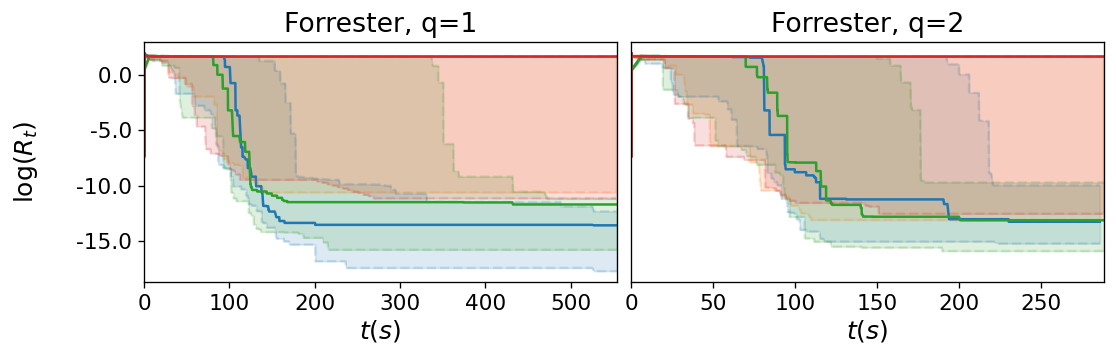

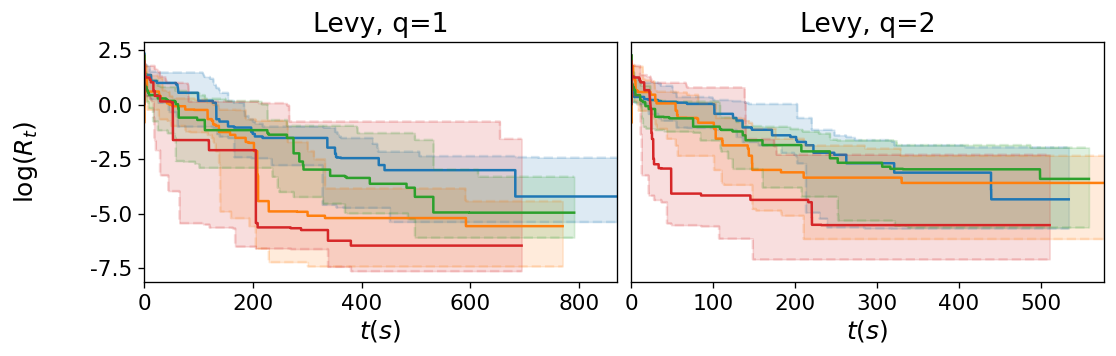

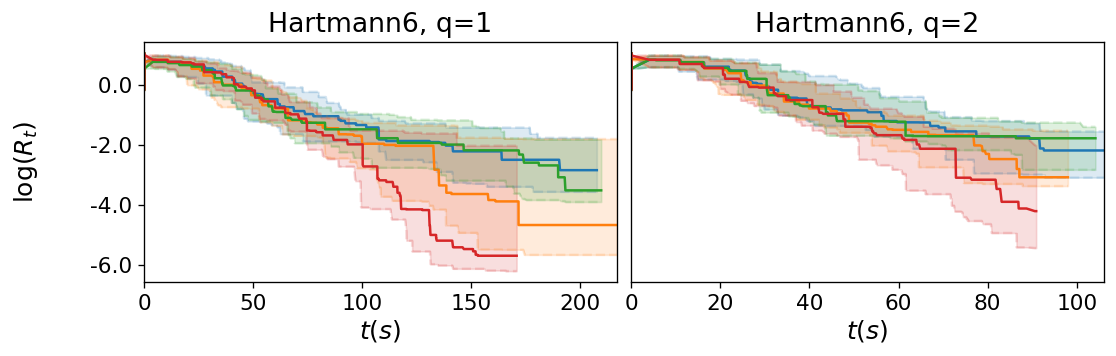

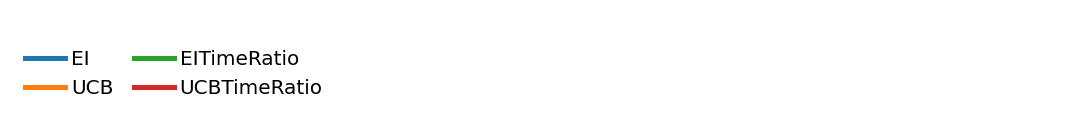

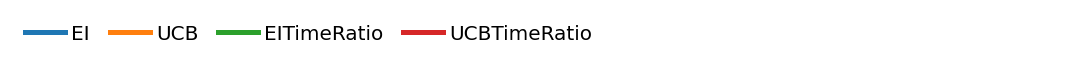

In [ ]:
import aegis
from aegis import util
import numpy as np
import plotting

D = plotting.read_in_results(
    [time_func for time_func, _ in time_functions], workers, problems, methods, num_runs, max_steps, bo_names
)

TITLE_FONTSIZE = 16#19
LABEL_FONTSIZE = 15#18
TICK_FONTSIZE = 13#16

method_cols = (
    np.array(
        [
            [31, 119, 180],
            [255, 127, 14],
            [44, 160, 44],
            [214, 39, 40],
            [148, 103, 189],
            [227, 119, 194],
        ]
    )
    / 255
)

for time_func, interface in time_functions:
    plotting.make_conv_plots(
        D,
        time_func,
        problems,
        workers,
        max_steps,
        methods,
        method_cols,
        fname_prefix=None,
        TITLE_FONTSIZE=TITLE_FONTSIZE,
        LABEL_FONTSIZE=LABEL_FONTSIZE,
        TICK_FONTSIZE=TICK_FONTSIZE,
        savefig=False,
    )

# indices of the methods
# 0 Random
# 1 TS
# 2 KB
# 3 LP
# 4 PLaYBOOK
# 5 AEGiS-RS
# 6 AEGiS
aegis.plotting.make_legend(
    [v for (k, v) in methods.items()], 
    method_cols, 
#     onecol_inds=[0, 1, 2, 5, 3, 6, 4],
#     twocol_inds=[0, 2, 3, 4, 1, 5, 6],
    onecol_inds=list(range(len(methods))),
    twocol_inds=list(range(len(methods))),
    savefig=False,
    fname_prefix=None,
)